In [1]:
# !pip install transformers accelerate datasets diffusers Pillow==9.4.0

# Load CIFAR10 dataset

In [1]:
from datasets import load_dataset, Dataset, DatasetDict

ds = load_dataset("uoft-cs/cifar10")
ds["train"]

Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})

In [2]:
d=ds["train"][0]
d

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 0}

# Load DCAE

In [3]:
import torch
from diffusers import AutoencoderDC
from transformers import Gemma2Model, GemmaTokenizerFast

model = "Efficient-Large-Model/Sana_600M_1024px_diffusers"
dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

dcae = AutoencoderDC.from_pretrained(model, subfolder="vae", torch_dtype=dtype).to(device)

# PIL to latent

10 images sizes: [(32, 32), (32, 32), (32, 32), (32, 32), (32, 32), (32, 32), (32, 32), (32, 32), (32, 32), (32, 32)]


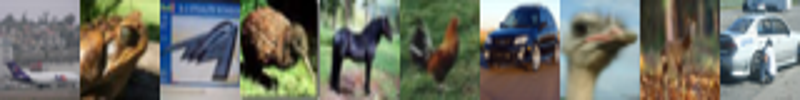

10  transformed images sizes: [(128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128)]


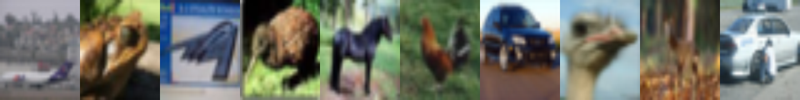

latents shape torch.Size([10, 32, 4, 4])
10  decoded latents sizes: [(128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128)]


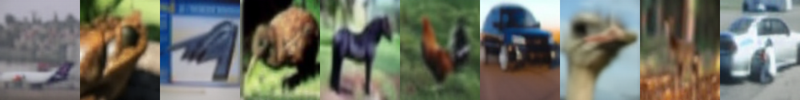

In [4]:
import torchvision.transforms as T
from utils import make_grid, PILs_to_latents, latent_to_PIL

## CHANGE ME!!!
resizeTo = 128

transform = T.Compose([
    T.Resize(resizeTo, antialias=True) if resizeTo is not None else skipT,
    T.CenterCrop(resizeTo),
    T.RandomHorizontalFlip(),
])

images = [ds["train"][i]["img"] for i in range(10)]
print(len(images), "images", "sizes:", [img.size for img in images])
display(make_grid(images).resize((800, 100)))

images_transformed = [transform(img) for img in images]
print(len(images_transformed), " transformed images", "sizes:", [img.size for img in images_transformed])
display(make_grid(images_transformed).resize((800, 100)))

latents = PILs_to_latents(images_transformed, dcae)
print("latents shape", latents.shape)

latents_decoded = [latent_to_PIL(latents[i, None], dcae) for i in range(len(images))]
print(len(latents_decoded), " decoded latents", "sizes:", [img.size for img in latents_decoded])
display(make_grid(latents_decoded).resize((800, 100)))

# Process CIFAR10 and upload

In [5]:
from torch.utils.data import DataLoader

def collate(items):
    labels = [item["label"] for item in items]
    images = [item["img"] for item in items]
    return labels, images

dataloader = DataLoader(ds["train"], batch_size = 4, shuffle=False, collate_fn=collate)
sample = next(iter(dataloader))
sample

([0, 6, 0, 2],
 [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>])

In [8]:
from tqdm import tqdm

dataset_latents = {}
splits = ["train", "test"]
batch_size = 256

for split in splits:
    dataloader = DataLoader(ds[split], batch_size = batch_size, shuffle=False, collate_fn=collate)
    dataset_latents[split]=[]
    
    for labels, images in tqdm(dataloader):
        images = [transform(img) for img in images]
        latents = PILs_to_latents(images, dcae).float().cpu()
    
        for i, label in enumerate(labels):
            latent = latents[i, None]
            dataset_latents[split].append({
                "label": label,
                "latent": latent.numpy()
            })
        

100%|███████████████████████████████████████████| 40/40 [00:29<00:00,  1.35it/s]


In [9]:
dataset = DatasetDict({split: Dataset.from_list(dataset_latents[split]) for split in splits})
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'latent'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['label', 'latent'],
        num_rows: 10000
    })
})

In [10]:
dataset["train"][0]["label"]

0

split train
9


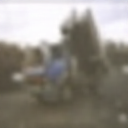

2


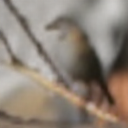

6


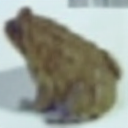

1


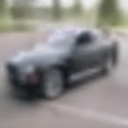

6


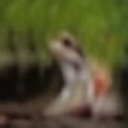

split test
9


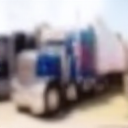

4


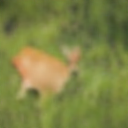

0


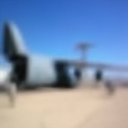

1


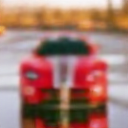

9


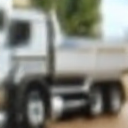

In [12]:
import random 

# check a few samples
for split in splits:
    print("split", split)
    for idx in [random.randint(0, len(dataset[split])-1) for _ in range(5)]:
        latent = torch.Tensor(dataset[split][idx]["latent"])
        label = dataset[split][idx]["label"]
        print(label)
        display(latent_to_PIL(latent.to(dcae.dtype).to(dcae.device), dcae))

In [13]:
dataset.push_to_hub("g-ronimo/CIFAR10-256-latents_dc-ae-f32c32-sana-1.0", private=False, commit_message=model)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/50 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/g-ronimo/CIFAR10-256-latents_dc-ae-f32c32-sana-1.0/commit/8b6735f85dd9e32ebe6e6c6c8f71f7a9ab10d12f', commit_message='Efficient-Large-Model/Sana_600M_1024px_diffusers', commit_description='', oid='8b6735f85dd9e32ebe6e6c6c8f71f7a9ab10d12f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/g-ronimo/CIFAR10-256-latents_dc-ae-f32c32-sana-1.0', endpoint='https://huggingface.co', repo_type='dataset', repo_id='g-ronimo/CIFAR10-256-latents_dc-ae-f32c32-sana-1.0'), pr_revision=None, pr_num=None)